In [3]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import json
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix, hstack

# conda install -c conda-forge lightgbm 
#import lightgbm as lgb

The following code will help to throw away all HTML tags from article content/title.

In [4]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [5]:
PATH_TO_DATA = './data'

Supplementary function to read a JSON line without crashing on escape characters.

In [6]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

This function takes a JSON and forms a txt file leaving only article titles. When you resort to feature engineering and extract various features from articles, a good idea is to modify this function.

#### Fields available in the json_data:

```js
['_id', '_timestamp', '_spider', 'url', 'domain', 'published',
 'title', 'content', 'author', 'image_url', 'tags', 'link_tags', 'meta_tags']
```

### Extract content

In [7]:
def remove_punctuation(text):
    
    # Tokenize the string into words
    #tokens = word_tokenize(text)
    tokens = text.split()

    # Remove non-alphabetic tokens, such as punctuation
    words = [word.lower() for word in tokens if word.isalpha()]
    return ' '.join(words)

In [8]:
def extract_content_from_json(path_to_inp_json_file, path_to_out_txt_file, total_length):
    '''
    :param path_to_inp_json_file: path to a JSON file with train/test data
    :param path_to_out_txt_file: path to extracted features (here titles), one per line
    :param total_length: we'll pass the hardcoded file length to make tqdm even more convenient
    '''
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file, \
         open(path_to_out_txt_file, 'w', encoding='utf-8') as out_file:
        for line in tqdm_notebook(inp_file, total=total_length):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = remove_punctuation(strip_tags(content))
            out_file.write(content_no_html_tags + '\n')

In [9]:
%%time
extract_content_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'train.json'),
           path_to_out_txt_file='train_content.txt', total_length=62313)


CPU times: user 3min 24s, sys: 2.11 s, total: 3min 26s
Wall time: 3min 26s


In [10]:
%%time
extract_content_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'test.json'),
           path_to_out_txt_file='test_content.txt', total_length=34645)


CPU times: user 1min 53s, sys: 1.17 s, total: 1min 54s
Wall time: 1min 54s


### Extract titles

In [11]:
def extract_titles_from_json(path_to_inp_json_file, path_to_out_txt_file, total_length):
    '''
    :param path_to_inp_json_file: path to a JSON file with train/test data
    :param path_to_out_txt_file: path to extracted features (here titles), one per line
    :param total_length: we'll pass the hardcoded file length to make tqdm even more convenient
    '''
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file, \
         open(path_to_out_txt_file, 'w', encoding='utf-8') as out_file:
        for line in tqdm_notebook(inp_file, total=total_length):
            json_data = read_json_line(line)
            content = json_data['title'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = remove_punctuation(strip_tags(content))
            out_file.write(content_no_html_tags + '\n')

In [12]:
%%time
extract_titles_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'train.json'),
           path_to_out_txt_file='train_titles.txt', total_length=62313)


CPU times: user 13.3 s, sys: 719 ms, total: 14 s
Wall time: 14.1 s


In [13]:
%%time
extract_titles_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'test.json'),
           path_to_out_txt_file='test_titles.txt', total_length=34645)


CPU times: user 7.43 s, sys: 337 ms, total: 7.77 s
Wall time: 7.75 s


### Extract authors

In [14]:
def extract_authors_from_json(path_to_inp_json_file, path_to_out_txt_file, total_length):
    '''
    :param path_to_inp_json_file: path to a JSON file with train/test data
    :param path_to_out_txt_file: path to extracted features (here titles), one per line
    :param total_length: we'll pass the hardcoded file length to make tqdm even more convenient
    '''
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file, \
         open(path_to_out_txt_file, 'w', encoding='utf-8') as out_file:
        for line in tqdm_notebook(inp_file, total=total_length):
            json_data = read_json_line(line)
            # {'name': None, 'url': 'https://medium.com/@Medium', 'twitter': '@Medium'}
            authors = json_data['author']['url'].replace('\n', ' ').replace('\r', ' ')
            out_file.write(authors + '\n')

In [15]:
%%time
extract_authors_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'train.json'),
           path_to_out_txt_file='train_authors.txt', total_length=62313)


CPU times: user 12.5 s, sys: 598 ms, total: 13.1 s
Wall time: 13 s


In [16]:
%%time
extract_authors_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'test.json'),
           path_to_out_txt_file='test_authors.txt', total_length=34645)


CPU times: user 6.97 s, sys: 338 ms, total: 7.31 s
Wall time: 7.29 s


### Extract Published

In [17]:
def extract_published_from_json(path_to_inp_json_file, path_to_out_txt_file, total_length):
    '''
    :param path_to_inp_json_file: path to a JSON file with train/test data
    :param path_to_out_txt_file: path to extracted features (here titles), one per line
    :param total_length: we'll pass the hardcoded file length to make tqdm even more convenient
    '''
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file, \
         open(path_to_out_txt_file, 'w', encoding='utf-8') as out_file:
        for line in tqdm_notebook(inp_file, total=total_length):
            json_data = read_json_line(line)
            # {'$date': '2015-08-03T07:44:50.331Z'}
            published = json_data['published']['$date'].replace('\n', ' ').replace('\r', ' ')
            out_file.write(published + '\n')

In [18]:
%%time
extract_published_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'train.json'),
           path_to_out_txt_file='train_published.txt', total_length=62313)


CPU times: user 12.5 s, sys: 616 ms, total: 13.1 s
Wall time: 13.1 s


In [19]:
%%time
extract_published_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'test.json'),
           path_to_out_txt_file='test_published.txt', total_length=34645)


CPU times: user 6.93 s, sys: 326 ms, total: 7.26 s
Wall time: 7.24 s


## Add features

### Add Content features

In [20]:
#stop_words="english"
tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1, 2), analyzer="word", stop_words="english")
#tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1, 2))


#, analyzer="word", stop_words="english"

In [21]:
%%time
with open('./train_content.txt') as input_train_file:
    X_train_content_sparse = tfidf.fit_transform(input_train_file)

#X_train = hstack([X_train, X_train_author_sparse]).tocsr()

CPU times: user 2min 53s, sys: 6.07 s, total: 2min 59s
Wall time: 2min 57s


In [22]:
%%time
#with open('./test_content.txt', encoding='utf-8') as input_train_file:
with open('./test_content.txt') as input_train_file:
    X_test_content_sparse = tfidf.transform(input_train_file)
    #X_test = tfidf.fit_transform(input_train_file)

#X_train = hstack([X_train, X_train_author_sparse]).tocsr()

CPU times: user 36.2 s, sys: 330 ms, total: 36.6 s
Wall time: 36.6 s


### Add title features
We'll use a very simple feature extractor – TfidfVectorizer, meaning that we resort to the Bag-of-Words approach. For now, we are leaving only 50k features.

In [23]:
# #, analyzer="word", stop_words="english"

tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), analyzer="word", stop_words="english")

In [24]:
%%time
with open('train_titles.txt', encoding='utf-8') as input_train_file:
    X_train_title_sparse = tfidf.fit_transform(input_train_file)
    #X_train_content = tfidf.fit_transform(input_train_file)
    #X_train = hstack([X_train, X_train_content]).tocsr()

CPU times: user 3.09 s, sys: 74.8 ms, total: 3.16 s
Wall time: 2.12 s


In [25]:
#%%time
#with open('train_titles.txt', encoding='utf-8') as input_train_file:
#    X_train = tfidf.fit_transform(input_train_file)

In [26]:
%%time
with open('test_titles.txt', encoding='utf-8') as input_test_file:
    X_test_title_sparse = tfidf.transform(input_test_file)
    #X_test_content = tfidf.transform(input_test_file)
    #X_test = hstack([X_test, X_test_content])

CPU times: user 1.35 s, sys: 14.1 ms, total: 1.37 s
Wall time: 506 ms


In [27]:
#%%time
#with open('test_titles.txt', encoding='utf-8') as input_test_file:
#    X_test = tfidf.transform(input_test_file)

In [28]:
X_train_title_sparse.shape, X_test_title_sparse.shape

((62313, 50000), (34645, 50000))

Read targets from a file

In [29]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                        'train_log1p_recommends.csv'), 
                           index_col='id')

In [30]:
y_train = train_target['log_recommends'].values

Target is still somewhat skewed, though it's allready log1p-transformed (#claps with log1p transformation). Yet, we'll apply log1p once more time.

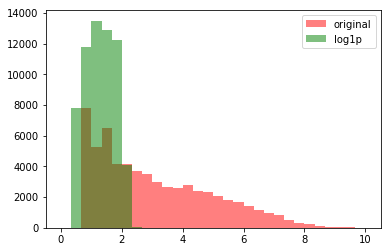

In [31]:
plt.hist(y_train, bins=30, alpha=.5, color='red', 
         label='original', range=(0,10));
plt.hist(np.log1p(y_train), bins=30, alpha=.5, color='green', 
         label='log1p', range=(0,10));
plt.legend();

### Add author feature

In [32]:
train_author_df = pd.read_csv('./train_authors.txt', header=None, names=['author'])
train_author_df.head(3)

,author
0,https://medium.com/@Medium
1,https://medium.com/@Medium
2,https://medium.com/@aelcenganda


In [33]:
test_author_df = pd.read_csv('./test_authors.txt', header=None, names=['author'])
test_author_df.head(3)

,author
0,https://medium.com/@HITRECORD.org
1,https://medium.com/@mariabustillos
2,https://medium.com/@HITRECORD.org


Create a united dataframe of author data for one hot encoding the author data

In [34]:
# United dataframe of the author data 
full_author_df = pd.concat([train_author_df, test_author_df])

# Index to split the training and test data sets
idx_split = train_author_df.shape[0]

In [35]:
onehotencoder = OneHotEncoder(categories='auto')
X_full_author_sparse = onehotencoder.fit_transform(full_author_df).toarray()

In [36]:
X_full_author_sparse.shape

(96958, 45374)

Split the authors back into training and test sets 

In [37]:
X_train_author_sparse = X_full_author_sparse[:idx_split,:]

In [38]:
X_test_author_sparse = X_full_author_sparse[idx_split:,:]

In [39]:
print(X_train_author_sparse.shape)
print(X_test_author_sparse.shape)

(62313, 45374)
(34645, 45374)


In [40]:
#%%time
#X_train = hstack([X_train, X_train_author_sparse]).tocsr()

In [41]:
#%%time
#X_test = hstack([X_test, X_test_author_sparse]).tocsr()

In [42]:
#print(X_train.shape)
#print(X_test.shape)

In [43]:
#def add_author_features(df, X_sparse):
#    onehotencoder = OneHotEncoder(categories='auto')
#    authors_sparse = onehotencoder.fit_transform(df).toarray()
#    
#    X = hstack([X_sparse, authors_sparse]).tocsr()
#    return X

In [44]:
#%%time
#X_train = add_author_features(train_author_df, X_train)

In [45]:
#%%time
#X_test = add_author_features(test_author_df, X_test)

### Add date time features

In [46]:
train_published_df = pd.read_csv('./train_published.txt',
                           header=None, names=['published'], parse_dates=['published'])
test_published_df = pd.read_csv('./test_published.txt',
                           header=None, names=['published'], parse_dates=['published'])

In [47]:
#def add_time_features(df, X_sparse):    
def add_time_features(df):    
    hour = df['published'].apply(lambda ts: ts.hour)
    
    morning = ((hour >= 7) & (hour <= 11)).astype('int')
    day = ((hour >= 12) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 6)).astype('int')
    
    dayofweek = df['published'].apply(lambda ts: ts.dayofweek)
    is_weekday = ((dayofweek == 5) | (dayofweek == 6)).astype('int')

    onehotencoder = OneHotEncoder(categories='auto')
    hour_published_hot_encoded = onehotencoder.fit_transform(hour.values.reshape(-1, 1)).toarray()

    month_published = df['published'].apply(lambda ts: ts.month).astype('int')
    onehotencoder = OneHotEncoder(categories='auto')
    month_published_hot_encoded = onehotencoder.fit_transform(month_published.values.reshape(-1, 1)).toarray()

    
    empty_sparse_matrix = csr_matrix((df.shape[0], 0))
    X = hstack([empty_sparse_matrix,
                morning.values.reshape(-1, 1),
                day.values.reshape(-1, 1),
                evening.values.reshape(-1, 1),
                night.values.reshape(-1, 1),
                is_weekday.values.reshape(-1,1),
                #month_published_hot_encoded # #ignore for now - the test set does not have data for all 12 months
                hour_published_hot_encoded  
                ]).tocsr()
    return X

In [48]:
%%time
X_train_time_features_sparse = add_time_features(train_published_df)

CPU times: user 586 ms, sys: 44.1 ms, total: 631 ms
Wall time: 629 ms


In [49]:
%%time
X_test_time_features_sparse = add_time_features(test_published_df)

CPU times: user 355 ms, sys: 2.49 ms, total: 358 ms
Wall time: 357 ms


### Join all sparse matrices

In [50]:
%%time
#X_train_sparse = X_train_author_sparse
X_train = hstack([X_train_author_sparse,
                         X_train_time_features_sparse,
                         X_train_title_sparse,
                         X_train_content_sparse
                        ]).tocsr()

CPU times: user 32 s, sys: 15 s, total: 47 s
Wall time: 44.6 s


In [51]:
%%time
#X_test_sparse = X_test_author_sparse
X_test = hstack([X_test_author_sparse,
                        X_test_time_features_sparse,
                        X_test_title_sparse,
                        X_test_content_sparse
                       ]).tocsr()

CPU times: user 18.2 s, sys: 9.45 s, total: 27.6 s
Wall time: 16min 24s


In [52]:
print(X_train.shape)
print(X_test.shape)

(62313, 195403)
(34645, 195403)


## Validation and model training
Let's make a 30%-holdout set.

In [53]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part = X_train[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid =  X_train[train_part_size:, :]
y_valid = y_train[train_part_size:]

Now we are ready to fit a linear model.

In [54]:
ridge = Ridge(random_state=17)

In [55]:
%%time
ridge.fit(X_train_part, np.log1p(y_train_part));

CPU times: user 45.1 s, sys: 1.26 s, total: 46.4 s
Wall time: 31min 37s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

After log1p-transformation, we need to apply an inverse  expm1-transformation to predictions.

In [56]:
ridge_pred = np.expm1(ridge.predict(X_valid))

In [57]:
ridge_valid_mae = mean_absolute_error(y_valid, ridge_pred)
ridge_valid_mae # 1.0830558622691648

1.0964515447926269

Then, we fit a LightGBM model with mean_absolute_error as objective (it's important!).

In [58]:
# lgb_x_train_part = lgb.Dataset(X_train_part.astype(np.float32), label=np.log1p(y_train_part))

In [59]:
# lgb_x_valid = lgb.Dataset(X_valid.astype(np.float32), label=np.log1p(y_valid))

In [60]:
#param = {'num_leaves': 255, 
#         'objective': 'mean_absolute_error',
#         'metric': 'mae'}

In [61]:
# num_round = 200
# bst_lgb = lgb.train(param, lgb_x_train_part, num_round, valid_sets=[lgb_x_valid], early_stopping_rounds=20)

In [62]:
# lgb_pred = np.expm1(bst_lgb.predict(X_valid.astype(np.float32), num_iteration=bst_lgb.best_iteration))

Let's plot predictions and targets for the holdout set. Recall that these are #recommendations (= #claps) of Medium articles with the  np.log1p transformation.

In [63]:
#plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
#plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='Ridge', range=(0,10));
#plt.hist(lgb_pred, bins=30, alpha=.5, color='blue', label='Lgbm', range=(0,10));
#plt.legend();

As we can see, the prediction is far from perfect, and we get MAE  ≈  1.3 that corresponds to  ≈  2.7 error in #recommendations.

In [64]:
ridge_valid_mae = mean_absolute_error(y_valid, ridge_pred)
ridge_valid_mae # 1.0964515447926269

1.0964515447926269

In [65]:
# lgb_valid_mae = mean_absolute_error(y_valid, lgb_pred)
# lgb_valid_mae

## Simple blending
Now let's mix predictions. We's just pick up weights 0.6 for Lgbm and 0.4 for Ridge, but these are typically tuned via cross-validation.

In [66]:
# mean_absolute_error(y_valid, .4 * lgb_pred + .6 * ridge_pred)

Finally, train both models on the full accessible training set, make predictions for the test set and form submission files.

In [67]:
%%time
ridge.fit(X_train, np.log1p(y_train));

CPU times: user 45.5 s, sys: 469 ms, total: 46 s
Wall time: 44.9 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [68]:
%%time
ridge_test_pred = np.expm1(ridge.predict(X_test))

CPU times: user 124 ms, sys: 4.2 ms, total: 128 ms
Wall time: 121 ms


In [69]:
#lgb_x_train = lgb.Dataset(X_train.astype(np.float32), label=np.log1p(y_train))

In [70]:
#num_round = 60
#bst_lgb = lgb.train(param, lgb_x_train, num_round)

In [71]:
#lgb_test_pred = np.expm1(bst_lgb.predict(X_test.astype(np.float32)))

Here's a simple mix

In [72]:
# mix_pred = .4 * lgb_test_pred + .6 * ridge_test_pred

### Leaderboard probing
Now we apply a dirty hack. Originally, we made you come up with it by your own (as a part of an assignment, with only a hint from out side), but now it's described in this tutorial, written within a previous session of mlcourse.ai.

Submitting all zeros gives 4.33328. If you take a pen and a piece of paper and figure out what it means for MAE that all predictions are zeros, then you'll see that it's exactly the mean target value for the test set. We can compare it with mean target for training data and correspondingly adjust predictions. Looks like a dirty hack, however, the same thing is often done with time series prediction (even in production) - merely adjusting your predictions to a change in target variable distribution.

In [73]:
mean_test_target = 4.33328

In [74]:
# mix_test_pred_modif = mix_pred + mean_test_target - y_train.mean()
#mix_test_pred_modif = ridge_test_pred + mean_test_target - y_train.mean()

In [75]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA, 'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [76]:
# 1.49028,
write_submission_file(ridge_test_pred + mean_test_target - y_train.mean(), 'submissions/06-ridge_submission.csv')

In [ ]:
#write_submission_file(ridge_test_pred, 'submissions/03-medium-submission.csv') # 2.03034 # no probing

In [ ]:
#write_submission_file(lgb_test_pred + mean_test_target - y_train.mean(), 'submissions/03-lgb_submission.csv')

In [ ]:
#write_submission_file(mix_test_pred_modif, 'submissions/03-medium-submission-probing.csv')

As we can see, simple blending decreases MAE for both holdout predictions and on the leaderboard. However, I don't recommend to play with blending/stacking schemes un the beginning of the competition – it's crucially important to come up with good features first.

You can further improve your model in various ways. I've described them in this kernel. Go and compete, good luck! https://www.kaggle.com/kashnitsky/ridge-countvectorizer-baseline

### TODO implement this part from https://www.kaggle.com/kashnitsky/ridge-and-lightgbm-blending-hacking